In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import the necessary packages
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import numpy as np
import argparse
import imutils
import cv2
# %matplotlib notebook
# %matplotlib inline
import matplotlib.pyplot as plt
%matplotlib notebook
import os
# os.chdir("drive/My Drive/Colab Notebooks/Planogram-detection/")
!ls

 another_test.jpg       planogram_count2.ipynb	 segmented_image.jpg
 counting_task.png      planogram_count.ipynb	'selective search'
 count_results	        present.ipynb		 template_match.png
 croppedImages	        README.md		 test.jpg
 distance_measurement   result_count.png	 watershed
 img_rgb.jpg	        results
 kmeans_approach        segmentation_map2.png


In [3]:
def write_on_image(objects_with_count):
    written_images = []
    for object_and_count in objects_with_count:
        image = object_and_count["image"]
        w,h,c = image.shape
        image = cv2.resize(image,(512,512))
        count = object_and_count["count"]
        image = cv2.putText(image, "count: "+str(count),(150,150),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        image = cv2.resize(image,(512,int(h*512/w)))
        written_images.append(image)
    return written_images

def show_multiple_images(allimages):
    plt.figure()
    
    try:
        os.makedirs("count_results/")
    except:
        print("")
    num_rows = len(allimages)/10 +1
    num_cols = 10
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.2)
    for id, image in enumerate(allimages):
        cv2.imwrite("count_results/"+str(id)+".jpg",image)
        plt.subplot(num_rows, num_cols, id+1)
        plt.axis(False)
        plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

In [19]:
def show_image(image):
    fig = plt.Figure()
    plt.axis(False)
    fig = plt.Figure(figsize=(40,20), dpi=300)
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    plt.show()

In [5]:
image = cv2.imread('test.jpg')
originalImage = image.copy()

/home/ritvik/anaconda3/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


[INFO] 499 unique segments found



<IPython.core.display.Javascript object>


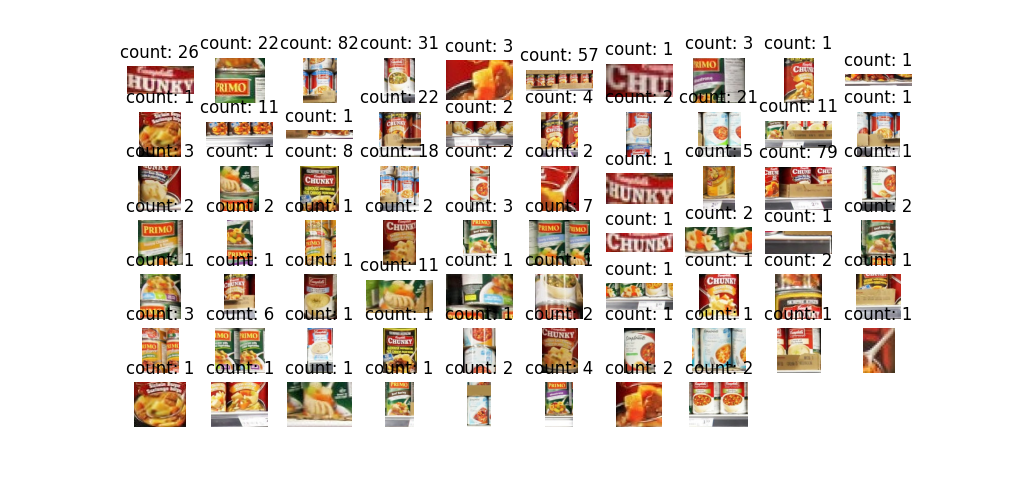

In [6]:
# load the image and perform pyramid mean shift filtering
# to aid the thresholding step
shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)

# convert the mean shift image to grayscale, then apply
# Otsu's thresholding
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# cv2.imshow("Thresh", thresh)
# show_image(thresh)

# compute the exact Euclidean distance from every binary
# pixel to the nearest zero pixel, then find peaks in this
# distance map
D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, indices=False, min_distance=20,labels=thresh)

# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

## delete and recreate cropped_images folder
try:
  os.rmdir("croppedImages/")
except:
  print("")

# os.makedirs("croppedImages/")

i=0
# loop over the unique labels returned by the Watershed algorithm
for label in np.unique(labels):
	# if the label is zero, we are examining the 'background'
	# so simply ignore it
	if label == 0:
		continue

	# otherwise, allocate memory for the label region and draw
	# it on the mask
	mask = np.zeros(gray.shape, dtype="uint8")
	mask[labels == label] = 255

	# detect contours in the mask and grab the largest one
	cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# draw a circle enclosing the object
	x, y, w, h = cv2.boundingRect(c)
	roi = originalImage[y:y+h, x:x+w]
	cv2.imwrite('croppedImages/'+str(label)+'.jpg',roi)
	cv2.rectangle(image, (int(x), int(y)), (int(x+w),int(y+h)), (0, 255, 0), 2)
	cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
	i=i+1

show_image(image)

In [7]:
show_image(image)
cv2.imwrite("segmented_image.jpg", image)

True

In [15]:
allTemplates = []
for template_name in os.listdir("croppedImages/"):
  template = cv2.imread("croppedImages/"+template_name)
  allTemplates.append(template)

fig = plt.Figure(figsize = (1000,1000), dpi = 300)

cols_count =10
rows_count = 5 #(len(np.unique(labels)/5) +1
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols)

for id, template_image in enumerate(allTemplates):
    plt.subplot(rows_count,cols_count,id+1)
    plt.axis(False)
    plt.imshow(cv2.cvtColor(template_image,cv2.COLOR_BGR2RGB))
    if(id==49):
        break
        
# plt.imsave("alltemplates.jpg",fig)
plt.show()

In [9]:
THRESHOLD_MATCH = 0.93
def filtersubset(allTemplates):
    count = 0
    counts = [1]*len(allTemplates)
    for id1,temp1 in enumerate(allTemplates):
        for id2,temp2 in enumerate(allTemplates):
            w1,h1,c = temp1.shape
            w2,h2,c = temp2.shape
            if((w1>w2)and(h1>h2)):
                #temp1 is bigger
                res = cv2.matchTemplate(temp1,temp2,cv2.TM_CCORR_NORMED)
                threshold = THRESHOLD_MATCH
                
                flag = False
                if np.amax(res)>threshold:
                    flag = True
                    if(counts[id1]==0):
                        continue
                        
                    counts[id1]+=counts[id2]
                    counts[id2] = 0
            
            if((w2>w1) and (h2>h1)):
                #temp2 is bigger
                res = cv2.matchTemplate(temp2,temp1,cv2.TM_CCORR_NORMED)
                threshold = THRESHOLD_MATCH
                
                
                flag = False
                if np.amax(res)>threshold:
                    flag = True
                    if(counts[id2]==0):
                        continue
                        
                    counts[id2]+=counts[id1]
                    counts[id1] = 0
                    
    return counts

In [10]:
filter_templates_count = filtersubset(allTemplates)

In [11]:
filter_templates_count

[0,
 26,
 22,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 82,
 0,
 0,
 0,
 0,
 31,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 57,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 11,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 22,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 21,
 0,
 0,
 0,
 0,
 0,
 11,
 0,
 1,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 8,
 0,
 0,
 18,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 79,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 0,
 3,
 0,
 0,
 

In [12]:
num = 0
for val in filter_templates_count:
    if(val>0):
        num+=1
    
print(num)

68


In [18]:
num_rows = num/10+1
num_cols = 10

fig = plt.Figure()

objects_with_count = []
current_count=1
for index, count in enumerate(filter_templates_count):
    if(count>0):
#         print(index)
        plt.subplot(num_rows,num_cols,current_count)
        template_image = allTemplates[index]
        plt.axis(False)
        plt.imshow(cv2.cvtColor(template_image,cv2.COLOR_BGR2RGB))
        plt.title("count: "+str(count))
#         object_and_count = {"image": template_image,"count":count}
        objects_with_count.append({"image": template_image,"count":count})
        current_count+=1

plt.show()     

/home/ritvik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>


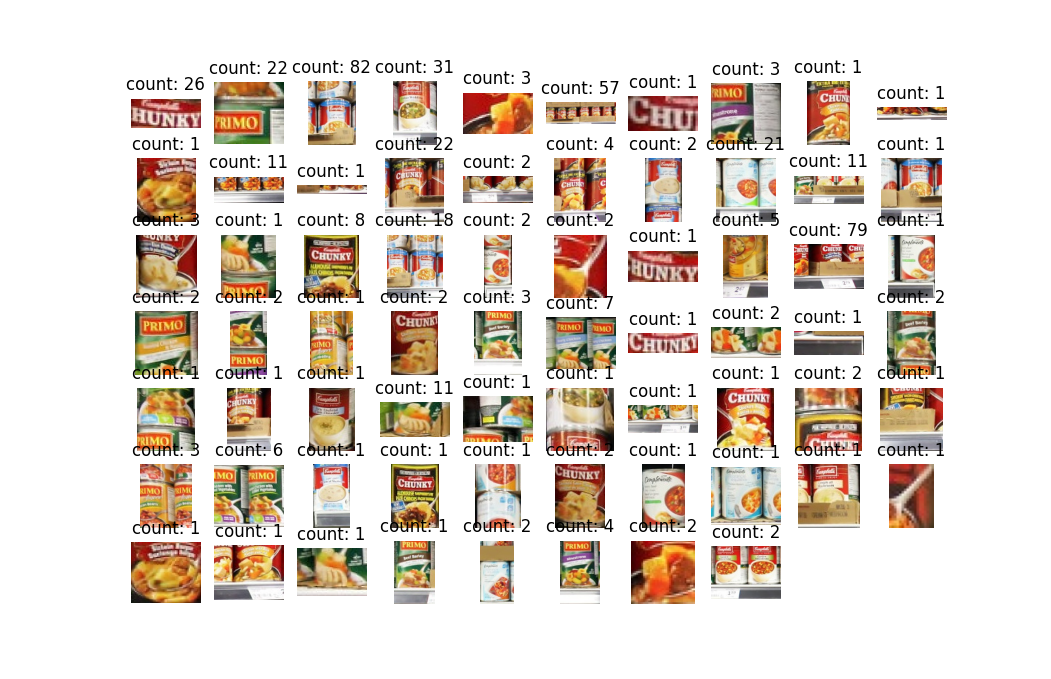

In [17]:
final_images = write_on_image(objects_with_count)
show_multiple_images(final_images)

# plt.imshow(cv2.cvtColor(final_images[0],cv2.COLOR_BGR2RGB))
# plt.axis(False)
# # plt.show()
# cv2.imwrite("another_test.jpg",final_images[1])